In [1]:
# Add parent directory to path so that we can import modules from the parent directory
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from llm import HuggingfacePipelineLLM, LLMGoalGenerator, DummyLLM
from utils import TextEmbedder, visualize_obs
from ellm_reward import ELLMRewardCalculator
from train_with_wrappers_and_sb3 import (make_env, 
                                         SIMILARITY_THRESHOLD,
                                         env_spec,
                                         CreateCompleteTextObs, 
                                         RewardIfActionSimilarToGoalSuggestionsFromLastStep, 
                                         GenerateGoalSuggestions, 
                                         EmbedTextObs,
                                         SharedState,
                                         make_full_eval_env,
                                         make_full_train_env)
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack


/Users/clara/anaconda3/envs/rl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
def visualize_n_frames(train_env, action, n_frames=5, show_goal_suggestions=False, frame_stack=1):
    # Test, if image and text description align, 
    # Test if FrameStack works correctly    
    for _ in range(n_frames):
        obs, _, _, _, info = train_env.step(action)
        goal_suggestions = train_env.shared_state.last_state_goal_suggestions if show_goal_suggestions else None
        visualize_obs(obs, goal_suggestions, frame_stack=frame_stack)

def visualize_vec_env_n_frames(train_env, action, n_frames=5, show_goal_suggestions=False, frame_stack=1):
    # Test, if image and text description align, 
    # Test if FrameStack works correctly    
    for _ in range(n_frames):
        obs, _, _, info = train_env.step(action)
        goal_suggestions = train_env.shared_state.last_state_goal_suggestions if show_goal_suggestions else None
        visualize_obs(obs, goal_suggestions, frame_stack=frame_stack)

In [4]:
language_model = DummyLLM(response="- don't eat animals",
                          cache_file="data/pkl") # for debugging other parts that do not need GPU, if you use this you don't need to submit a job to the cluster
goal_generator = LLMGoalGenerator(language_model=language_model)
obs_embedder = TextEmbedder()
reward_calculator = ELLMRewardCalculator()

# Some things need to be shared between wrappers, so we use a shared state object
shared_state = SharedState()

## 1. Test Basic Environment: Frame Stack and basic Text Oberservation

In [ ]:
# Test, if image and text description align, 
# Test if FrameStack works correctly
train_env = make_env(**env_spec)
obs, _ = train_env.reset()
visualize_n_frames(train_env, 3)

In [ ]:
obs['obs'].shape

## 2. Test Complete Text Obs. Environment: Append Inv and health status to observation 

In [ ]:
train_env = make_env(**env_spec)
train_env = CreateCompleteTextObs(train_env)
obs, _ = train_env.reset()
train_env.player.inventory['food']=5
train_env.player.inventory['drink']=4
train_env.player.inventory['diamond']=300
visualize_n_frames(train_env, 3)

## 3. Test Reward Wrapper: Not decoupled from Goal Generator possible

## 4. Test Goal Generator: Does LLM suggest goals? (dummy llm uses cache)

In [ ]:
train_env = make_env(**env_spec)
train_env = CreateCompleteTextObs(train_env)
train_env = RewardIfActionSimilarToGoalSuggestionsFromLastStep(train_env, reward_calculator, shared_state, similarity_threshold=SIMILARITY_THRESHOLD)
train_env = GenerateGoalSuggestions(train_env, goal_generator, shared_state) 
obs, _ = train_env.reset()
visualize_n_frames(train_env, 3, show_goal_suggestions=True)


## 5. Test Embedding: Is the text observation embedded? 

In [ ]:
train_env = make_env(**env_spec)
train_env = CreateCompleteTextObs(train_env)
train_env = RewardIfActionSimilarToGoalSuggestionsFromLastStep(train_env, reward_calculator, shared_state, similarity_threshold=SIMILARITY_THRESHOLD)
train_env = GenerateGoalSuggestions(train_env, goal_generator, shared_state) 
train_env = EmbedTextObs(train_env, obs_embedder)
obs, _ = train_env.reset()
visualize_n_frames(train_env, 3, show_goal_suggestions=True)

## 6. Check VecEnv

In [5]:
train_env = make_vec_env(make_full_train_env, 
                             n_envs=1, 
                             seed=env_spec['seed'], 
                             env_kwargs={'reward_calculator': reward_calculator, 
                                         'goal_generator': goal_generator, 
                                         'obs_embedder': obs_embedder, 
                                         'shared_state': shared_state, 
                                         'device': 'device',
                                         'debug':True,
                                         })
train_env = VecFrameStack(train_env, n_stack=env_spec['frame_stack'])

In [6]:
obs, info = train_env.reset()

/Users/clara/anaconda3/envs/rl/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:160: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Users/clara/anaconda3/envs/rl/lib/python3.11/site-packages/gymnasium/spaces/box.py:230: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Users/clara/anaconda3/envs/rl/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


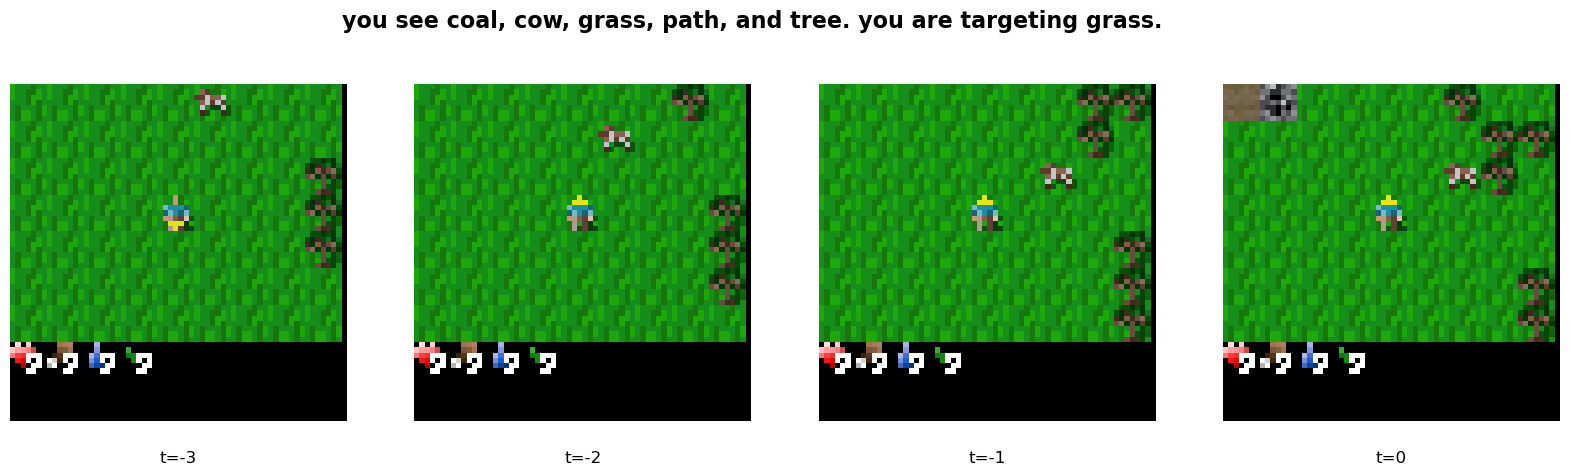

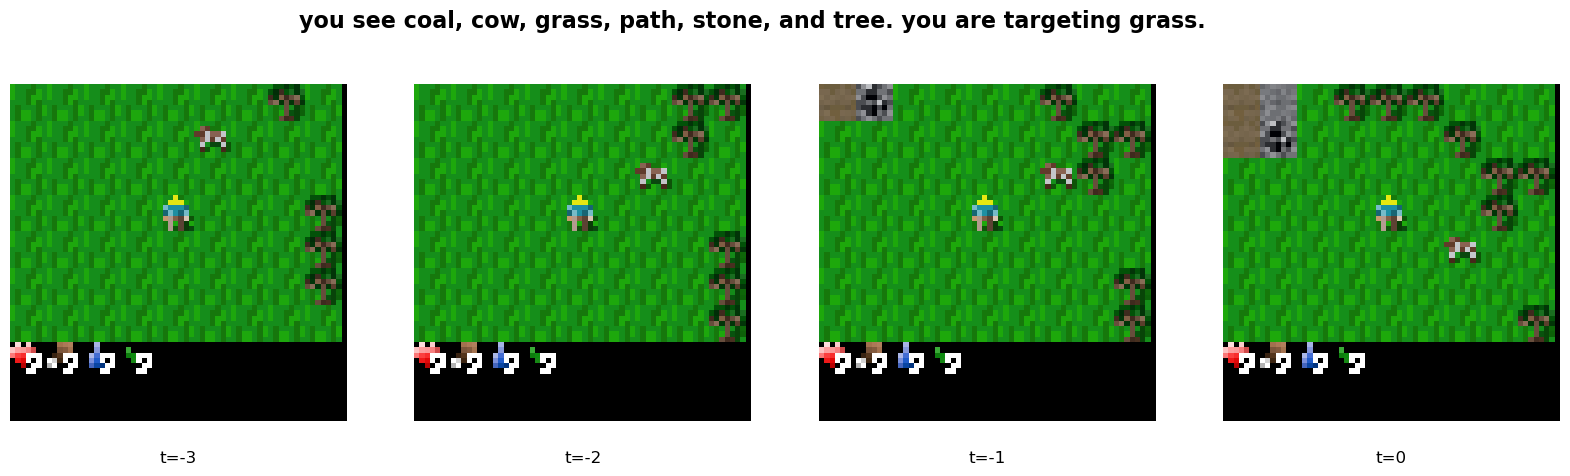

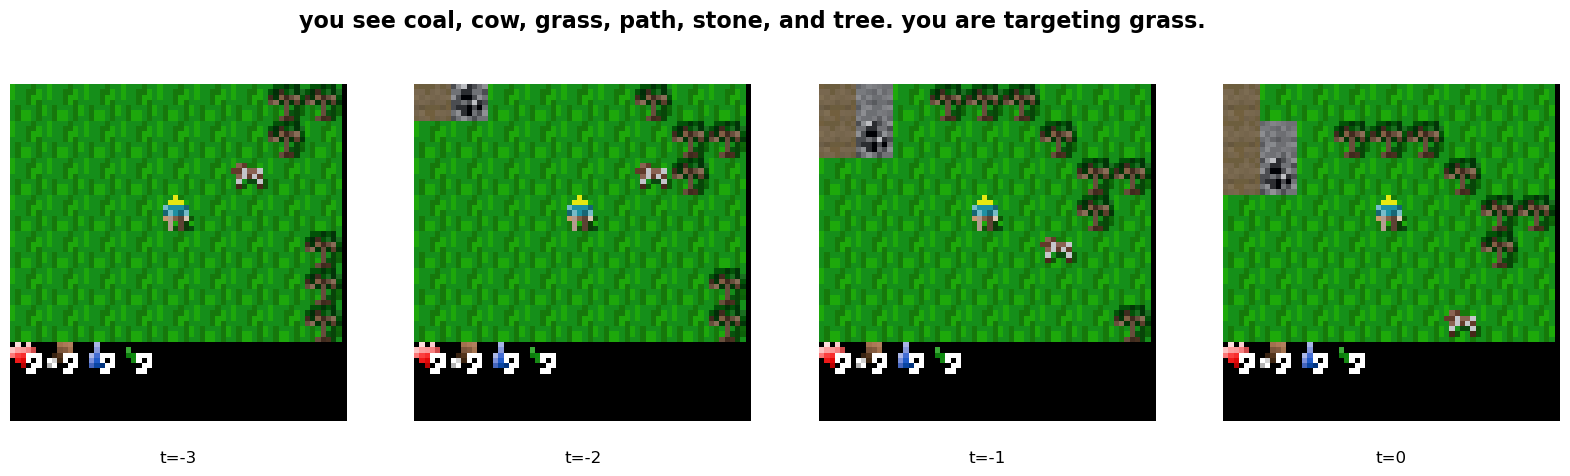

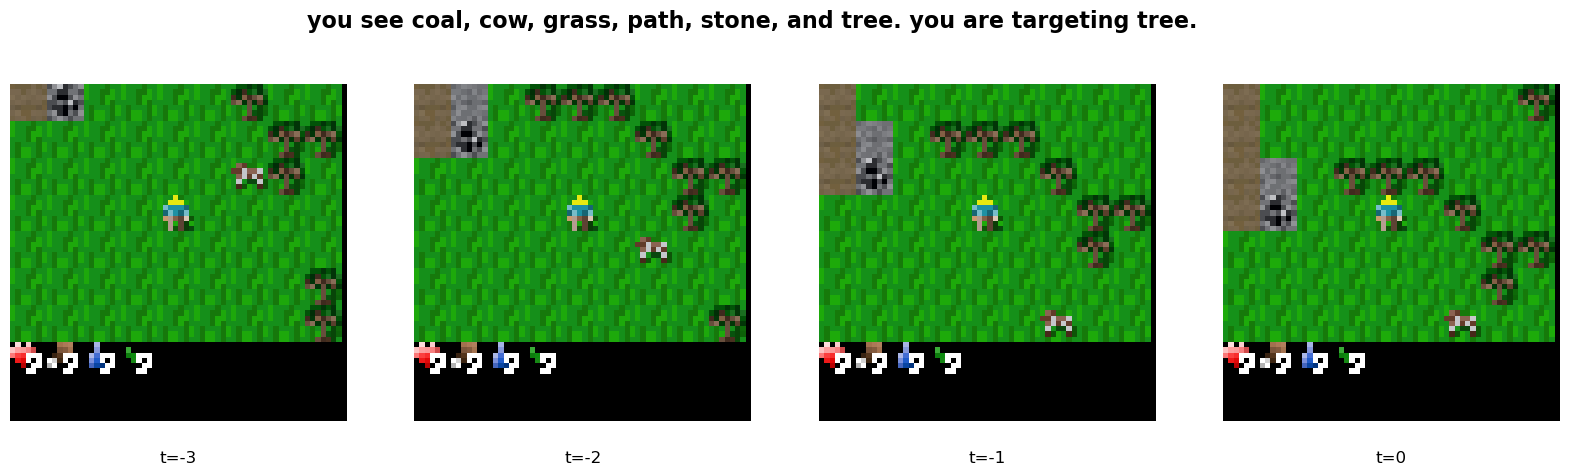

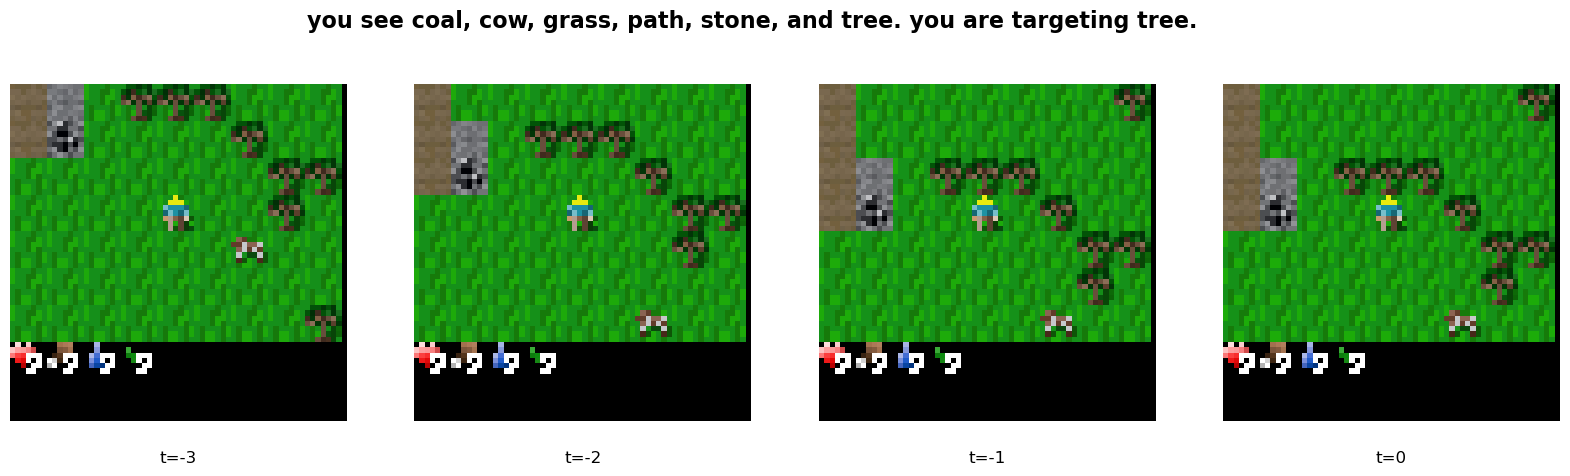

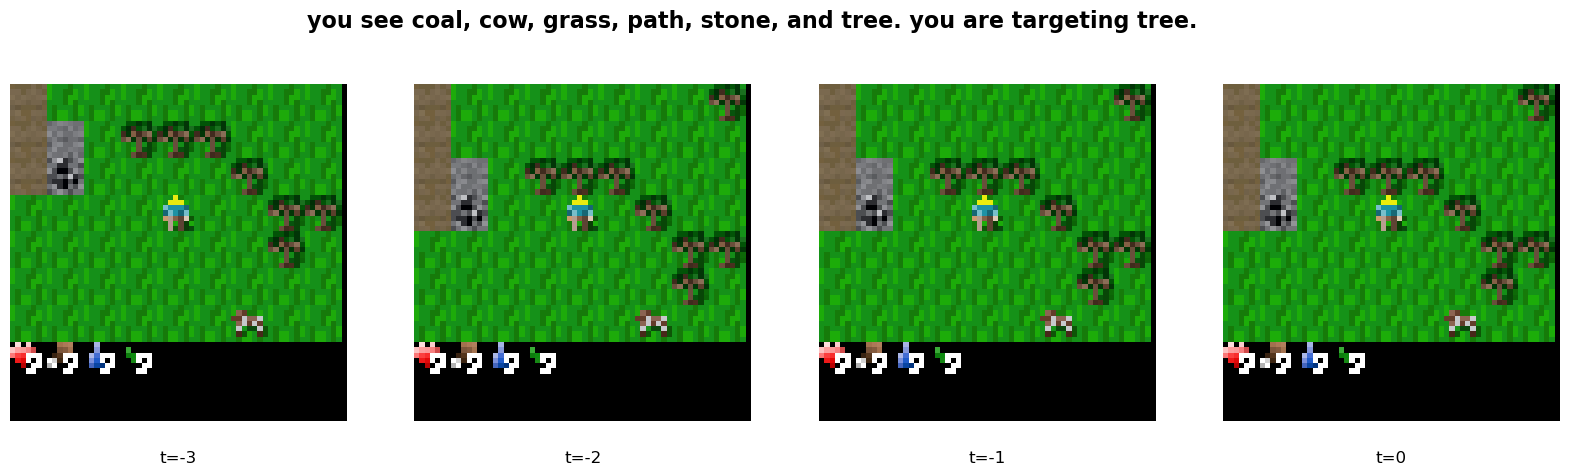

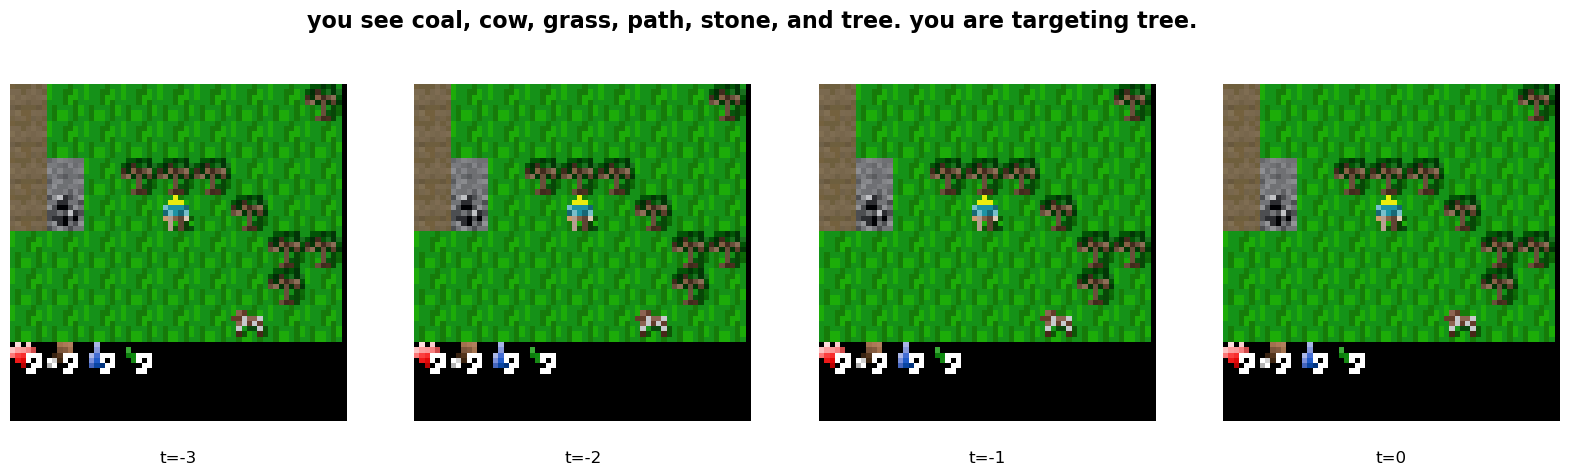

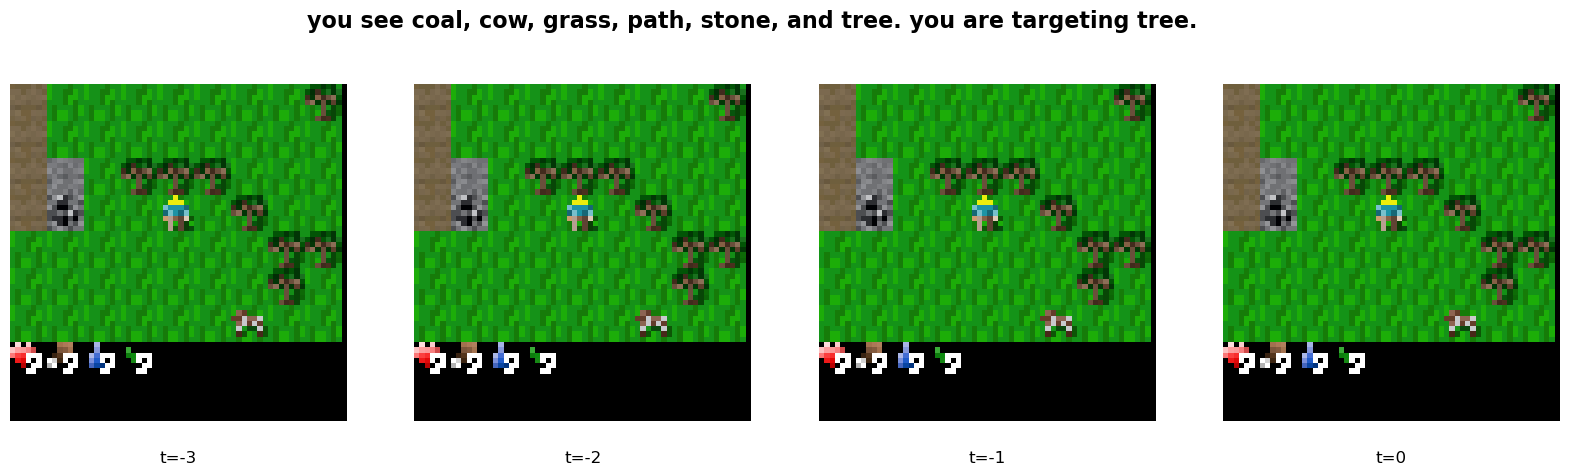

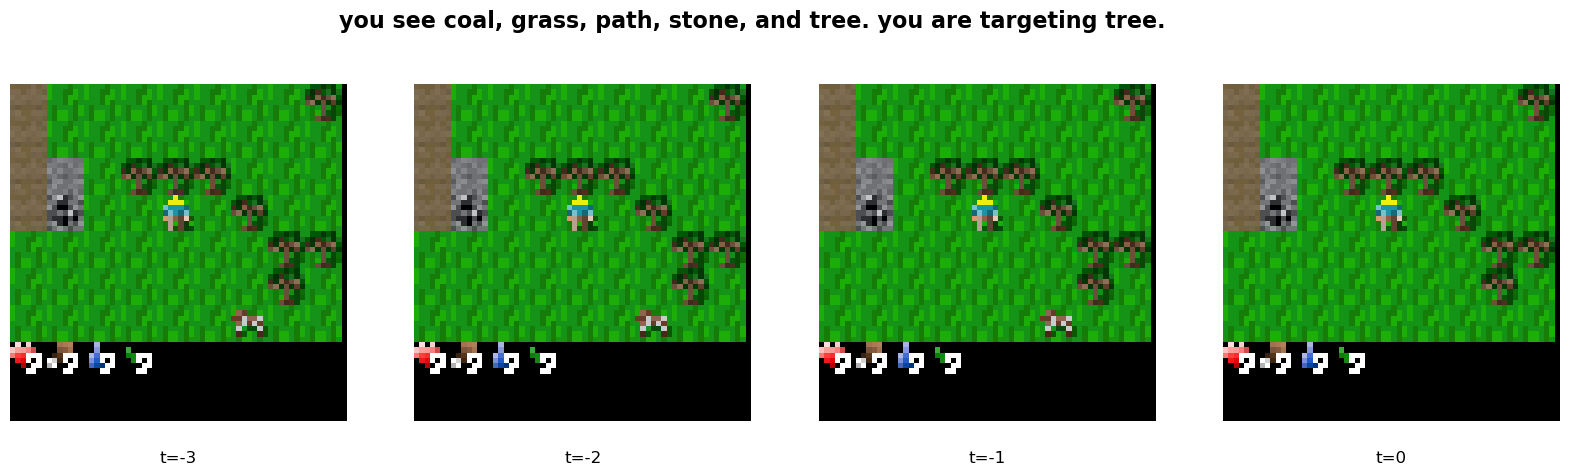

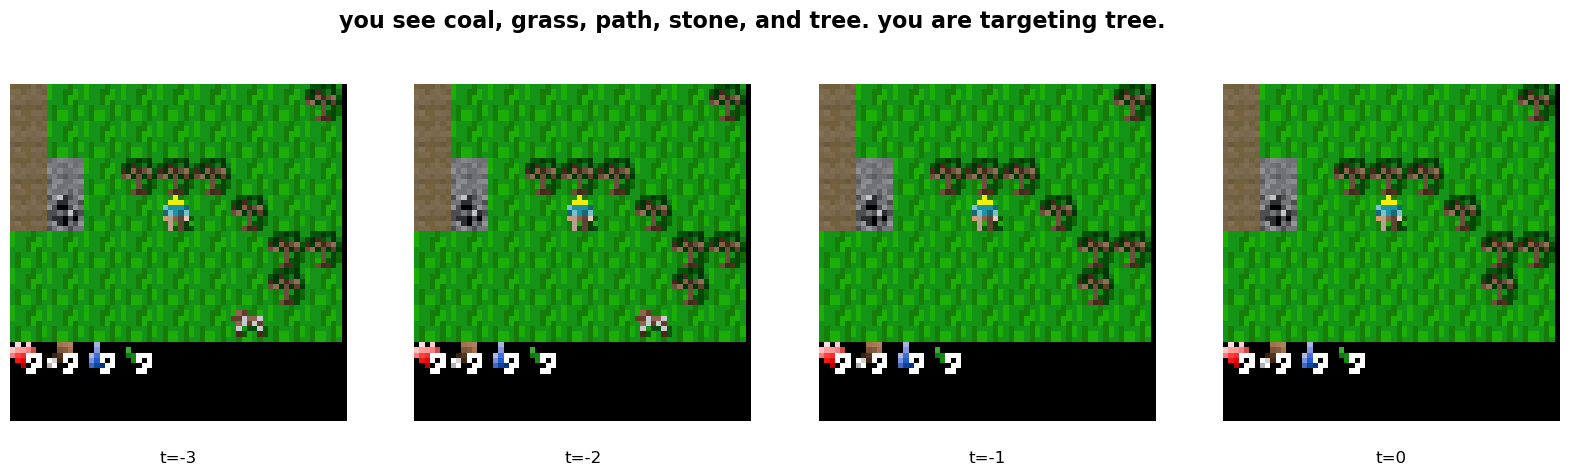

In [13]:
for i in range(10):
    obs, rewards, dones, infos = train_env.step(np.array([3]))
    frame_stack = 4
    fig, axs = plt.subplots(1, frame_stack, figsize=(5 * frame_stack, 5))
    title = infos[0]["text_obs"]
    fig.suptitle(title , fontsize=16, weight="bold" )
    if len(obs['obs'].shape) == 4:
        obs['obs'] = obs['obs'].squeeze()
    for i in range(frame_stack):
        frame = obs['obs'][:,:,i*3:(i+1)*3]
        axs[i].imshow(frame)
        axs[i].axis('off')
        axs[i].set_title(f't={i - frame_stack + 1}', y=-0.15)
    plt.show()

In [ ]:
obs['obs'].shape